In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import svm, feature_selection, linear_model, model_selection, metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import matplotlib.pylab as plb
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [18]:
df = pd.read_csv('big_clean_dataset.csv').drop(columns='Unnamed: 0')

In [19]:
df.head(2)

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,0.0,0.34375,0.0,0.324699,0.144998,0.0,0.0,0.028139,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.736364,0.815101,0.514205
1,0.0,0.34375,0.0,0.324699,0.145109,0.0,0.0,0.028139,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.736364,0.526681,0.747159


In [20]:
df.shape

(15866, 18)


Plotting elbow method...
2 10363.654578174937
4 6319.799415715196
6 5091.662322207705
8 4370.696357975062
10 3902.1830516669834
12 3558.386171088419
14 3286.3491668877805
16 3038.141725310565
18 2888.3676352587963
20 2717.0554807985436
22 2576.2611600253504
24 2476.312959761731
26 2355.436817717559
28 2257.1267731086473
30 2180.7701352963163
32 2116.168988371884
34 2011.1037761168104
36 1943.4635971458415
38 1902.5051300230361
40 1835.2035154513426
42 1779.12701878691
44 1738.0601380570124
46 1713.1772268199547
48 1664.5465828520153
50 1619.4592247222822
52 1594.6803086871303
54 1562.9110863825267
56 1519.2940433030228
58 1490.9303130446872
60 1469.0094051516821
62 1440.1365979851737
64 1412.7570855837193
66 1390.6644630027934
68 1361.9527106582875
70 1340.1185152934786
72 1316.6888264200845
74 1292.6618716595353
76 1279.8267247987053
78 1252.763200771616
80 1237.2126411632134
82 1220.7793062764952
84 1213.060048561537
86 1190.7675976476287
88 1183.6568466104752
90 1164.8215946276534


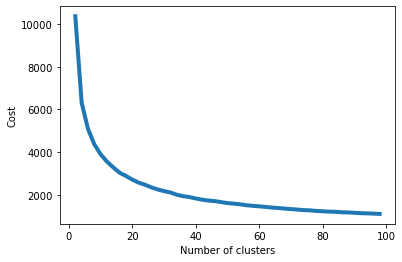

DONE


In [21]:
def elbow(data):
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 100, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")
    
elbow(df)

In [5]:
X0 = df.loc[:, df.columns != 'SALE PRICE'] 
Y0 = df['SALE PRICE'] 
trainX, testX, trainY, testY = model_selection.train_test_split(X0, Y0, test_size=0.30) 

In [9]:
knnm = KMeans(n_clusters=60, init='random', random_state=42)
knnm.fit(X0)

KMeans(init='random', n_clusters=60, random_state=42)

In [10]:
# predict the clusters for the data
y_pred = knnm.predict(testX)

# calculate Silhouette score for the clustering
silhouette = silhouette_score(testX, testY)

# better model has a higher Silhouette score
print(f"Silhouette score: {silhouette:.2f}")

# better model has a lower wcss(within-cluster sum of squares) score
wcss = knnm.inertia_
print(f"wcss score:{wcss}")

Silhouette score: -0.69
wcss score:1162.7859549856435


# Visualise the cluster data

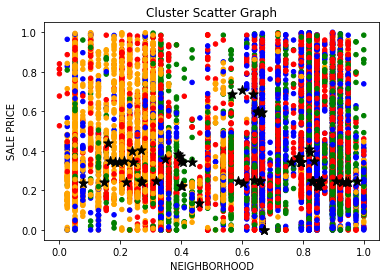

In [12]:
labels = knnm.predict(X0)
df['cluster'] = labels
colors = ['red', 'green', 'blue', 'orange']

# Create a scatter plot of the data, colored by cluster label, need list all columns
df.plot.scatter(x='NEIGHBORHOOD', y='SALE PRICE', c=df['cluster'].apply(lambda x: colors[x%len(colors)]))

# Plot the centroids of each cluster as black stars
plt.scatter(knnm.cluster_centers_[:, 0], knnm.cluster_centers_[:, 1], s=100, marker='*', color='black')

# Set the x and y axis labels and title of the plot
plt.xlabel('NEIGHBORHOOD')
plt.ylabel('SALE PRICE')
plt.title('Cluster Scatter Graph')

# Show the plot
plt.show()

# build the local regressor model

In [15]:
knnm.n_clusters

60

In [39]:
X0.columns

Index(['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
       'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER',
       'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE DATE'],
      dtype='object')

In [37]:
X0[labels ==3]

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE
10527,0.820513,0.21875,0.5,0.641358,0.004996,0.144144,0.0,0.043290,0.0,0.0,0.0,0.0,0.0,0.948833,0.333333,0.136364,1.000000
10531,0.820513,0.21875,0.5,0.643144,0.004219,0.144144,0.0,0.160173,0.0,0.0,0.0,0.0,0.0,0.948833,0.333333,0.136364,0.903409
10544,0.820513,0.21875,0.5,0.652970,0.001332,0.144144,0.0,0.160173,0.0,0.0,0.0,0.0,0.0,0.948833,0.333333,0.136364,0.792614
10553,0.820513,0.21875,0.5,0.660116,0.000777,0.144144,0.0,0.160173,0.0,0.0,0.0,0.0,0.0,0.943865,0.333333,0.136364,0.880682
10558,0.820513,0.21875,0.5,0.660116,0.003997,0.144144,0.0,0.160173,0.0,0.0,0.0,0.0,0.0,0.948833,0.333333,0.136364,0.826705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14832,0.923077,0.25000,0.5,0.554265,0.003664,0.216216,0.0,0.051948,0.0,0.0,0.0,0.0,0.0,0.948833,0.333333,0.209091,0.789773
14842,0.923077,0.25000,0.5,0.554265,0.005440,0.216216,0.0,0.051948,0.0,0.0,0.0,0.0,0.0,0.957774,0.333333,0.209091,0.818182
14844,0.923077,0.25000,0.5,0.554265,0.008216,0.216216,0.0,0.051948,0.0,0.0,0.0,0.0,0.0,0.944362,0.333333,0.209091,0.937500
14845,0.923077,0.25000,0.5,0.554265,0.008216,0.216216,0.0,0.051948,0.0,0.0,0.0,0.0,0.0,0.944362,0.333333,0.209091,0.917614


In [40]:
Y0[labels ==3]

10527    0.194581
10531    0.142857
10544    0.105911
10553    0.135468
10558    0.137931
           ...   
14832    0.738916
14842    0.788177
14844    0.285714
14845    0.230295
14848    0.261083
Name: SALE PRICE, Length: 629, dtype: float64

In [30]:
# build models based on clusters
labels = knnm.labels_
models = []
for i in range(knnm.n_clusters):
    X_cluster = X0[labels == i]
    y_cluster = Y0[labels == i]
    model = LinearRegression()
    model.fit(X_cluster, y_cluster)
    models.append(model)

In [48]:
testX.iloc[1]

NEIGHBORHOOD                      0.487179
BUILDING CLASS CATEGORY           0.343750
TAX CLASS AT PRESENT              0.500000
BLOCK                             0.413131
LOT                               0.333740
BUILDING CLASS AT PRESENT         0.738739
APARTMENT NUMBER                  0.006823
ZIP CODE                          0.032468
RESIDENTIAL UNITS                 0.011111
COMMERCIAL UNITS                  0.000000
TOTAL UNITS                       0.010417
LAND SQUARE FEET                  0.000000
GROSS SQUARE FEET                 0.000000
YEAR BUILT                        0.974665
TAX CLASS AT TIME OF SALE         0.333333
BUILDING CLASS AT TIME OF SALE    0.736364
SALE DATE                         0.230114
Name: 4328, dtype: float64

11117    0.598522
4328     0.201970
7407     0.000004
12552    0.944344
723      0.270936
           ...   
10950    0.517241
6146     0.009285
8528     0.028522
3007     0.492118
109      0.817734
Name: SALE PRICE, Length: 4760, dtype: float64

In [58]:
new_labels = knnm.predict(testX)
predictions = np.zeros(len(testX))
if not np.all(np.isin(new_labels, np.unique(knnm.labels_))):
    raise ValueError('Predicted cluster labels outside range of original labels')
for i in range(len(testX)):
    cluster_idx = new_labels[i]
    row = testX.iloc[i].values.reshape(1, -1)
    coefs = models[cluster_idx].coef_
    prediction = coefs.dot(row.T) + models[cluster_idx].intercept_
    predictions[i] = prediction

In [59]:
print(predictions)

[0.36328125 0.31046943 0.29237289 ... 0.03415287 0.3671875  0.42718263]


In [60]:
r2_score(testY, predictions)

0.4659750008757094